In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV


import xgboost as xgb
from utils import steps2ms

import pickle

def write(out, path):
    with open(path, 'wb') as f:
        pickle.dump(out, f)


# TODO
- use deviance explained instead of score
- identify PF cells
    - plot spk vs distance
    - model fit with distance-cosine basis
- offset column? bias column?

# Load preprocessed data

In [2]:
df_prc = pd.read_pickle('./data/preproc/df_prc.pickle') # preprocessed features and targest
ids_good = np.load('./data/preproc/ids_good.npy') # infos which trials are good
gr_prc = df_prc.groupby('trial') # data grouped by trials

# Create train and test sets

In [3]:
# 80 % train, 20 % test
# kf = KFold(20) # instead of train_test_split, each KFold is 95% train and 5% test (easier to change later)
# kfs = [ (i, j) for i, j in kf.split(ids_good) ] # expand generator
# ids_train, ids_test = kfs[-1] # -1 equivalent to 

ids_train, ids_test = train_test_split(ids_good, test_size=0.2, shuffle=True, random_state=42)

train = pd.concat([ gr_prc.get_group(s) for s in ids_train ])
test = pd.concat([ gr_prc.get_group(s) for s in ids_test ])

print('train trials:')
print(' '.join([str(i) for i in ids_train]))
print('test trials:')
print(' '.join([str(i) for i in ids_test]))

np.save('./data/preproc/ids_train.npy', ids_train)
np.save('./data/preproc/ids_test.npy', ids_test)

train trials:
128 27 23 32 48 139 16 45 152 153 10 34 118 132 29 41 6 116 125 40 36 17 166 35 130 8 44 129 136 28 20 151 156 26 9 164 50 14 140 25 4 18 39 148 7 167 158 154 117 51 161 47 146 124 168 163 42 121 49 157 120 138 33 171 122 126 169 38 30 160 2 115 22 3 24 150 162 137 149 145 21 123 134 15 155 114 165
test trials:
141 11 5 147 127 131 31 46 159 12 142 143 1 144 19 133 119 135 170 43 13 37


In [4]:
# select features and targets
col_set = lambda x: [ i for i in df_prc if i.startswith(x) ]

feat = [ 'dst' ] + ['vel'] + ['acc'] + col_set('cue_') + col_set('rwd_') + col_set('lck_') + col_set('blk_')
trg = col_set('unt_')

train_X, test_X = train.loc[:, feat], test.loc[:, feat]

print('There are {} input features:'.format(len(feat)))
print(' '.join(feat))
print('There are {} individual targets:'.format(len(trg)))
print(' '.join(trg))

write(trg, './data/preproc/targets.pickle')
write(feat, './data/preproc/features.pickle')

There are 39 input features:
dst vel acc cue_0 cue_1 cue_2 cue_3 cue_4 rwd_0 rwd_1 rwd_2 rwd_3 rwd_4 rwd_5 rwd_6 rwd_7 rwd_8 rwd_9 lck_0 lck_1 lck_2 lck_3 lck_4 lck_5 lck_6 lck_7 lck_8 lck_9 lck_10 blk_0 blk_1 blk_2 blk_3 blk_4 blk_5 blk_6 blk_7 blk_8 blk_9
There are 84 individual targets:
unt_1 unt_2 unt_3 unt_4 unt_5 unt_6 unt_7 unt_8 unt_9 unt_10 unt_11 unt_12 unt_13 unt_14 unt_15 unt_16 unt_17 unt_18 unt_19 unt_20 unt_21 unt_22 unt_23 unt_24 unt_25 unt_26 unt_27 unt_28 unt_29 unt_30 unt_31 unt_32 unt_33 unt_34 unt_35 unt_36 unt_37 unt_38 unt_39 unt_40 unt_41 unt_42 unt_43 unt_44 unt_45 unt_46 unt_47 unt_48 unt_49 unt_50 unt_51 unt_52 unt_53 unt_54 unt_55 unt_56 unt_57 unt_58 unt_59 unt_60 unt_61 unt_62 unt_63 unt_64 unt_65 unt_66 unt_67 unt_68 unt_69 unt_70 unt_71 unt_72 unt_73 unt_74 unt_75 unt_76 unt_77 unt_78 unt_79 unt_80 unt_81 unt_82 unt_83 unt_84


# Model fits

## Ordinary Least Squares

In [10]:
out = dict()
for i in trg:
    train_y, test_y = train.loc[:, i], test.loc[:, i]
    mod = LinearRegression().fit(train_X, train_y)
    out[i] = mod

write(out, './data/fits/mod_ols.pickle')

## Ridge regression

In [13]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mod', Ridge())
])

grd = GridSearchCV(
    pipe, 
    { 'mod__alpha': np.logspace(-6, 6, 13), }, 
    n_jobs=-1
)

out = dict()
for i in trg:
    train_y, test_y = train.loc[:, i], test.loc[:, i]

    mods = grd.fit(train_X, train_y)
    mod = mods.best_estimator_

    out[i] = mod

write(out, './data/fits/mod_ridge.pickle')

## XGBoost regression

### default

In [5]:
est = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)


pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mod', est)
])


out = dict()
for i in trg:
    train_y, test_y = train.loc[:, i], test.loc[:, i]

    mod = pipe.fit(train_X, train_y)
    out[i] = mod

write(out, './data/fits/mod_xgb_reg_default.pickle')

## grid search: max depth, learning rate, number of estimators

In [12]:
est = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)


pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mod', est)
])

grd = GridSearchCV(
    pipe, 
    {
        'mod__max_depth': [4, 5, 6],
        'mod__learning_rate': [0.01, 0.05, 0.1],
        'mod__n_estimators': [100, 500, 1000],
    }, 
    # n_jobs=-1,
    verbose=True,
    # scoring='r2',
)

out = dict()
for i in trg:
    train_y, test_y = train.loc[:, i], test.loc[:, i]

    mods = grd.fit(train_X, train_y)
    mod = mods.best_estimator_

    out[i] = mod

write(out, './data/fits/mod_xgb_reg_grid.pickle')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 

In [14]:
est = xgb.XGBRegressor(
    objective='count:poisson',
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)


pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mod', est)
])

grd = GridSearchCV(
    pipe, 
    {
        'mod__max_depth': [4, 5, 6],
        'mod__learning_rate': [0.01, 0.05, 0.1],
        'mod__n_estimators': [100, 500, 1000],
    }, 
    # n_jobs=-1,
    verbose=True,
    # scoring='r2',
)

out = dict()
for i in trg:
    train_y, test_y = train.loc[:, i], test.loc[:, i]

    mods = grd.fit(train_X, train_y)
    mod = mods.best_estimator_

    out[i] = mod

write(out, './data/fits/mod_xgb_reg_grid_pois.pickle')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 

## HalveGrid

In [10]:
est = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)


pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mod', est)
])

grd = HalvingGridSearchCV(
    pipe, 
    {
        'mod__max_depth': [4, 5, 6],
        'mod__learning_rate': [0.01, 0.05, 0.1],
        'mod__n_estimators': [100, 500, 1000],
    }, 
    # n_jobs=-1,
    verbose=True,
    # scoring='r2',
)

out = dict()
for i in trg[:2]:
    train_y, test_y = train.loc[:, i], test.loc[:, i]

    mods = grd.fit(train_X, train_y)
    mod = mods.best_estimator_

    out[i] = mod

write(out, './data/fits/mod_xgb_reg_halvgrid.pickle')

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 25439
max_resources_: 686870
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 25439
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 9
n_resources: 76317
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 2
n_candidates: 3
n_resources: 228951
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 1
n_resources: 686853
Fitting 5 folds for each of 1 candidates, totalling 5 fits
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 25439
max_resources_: 686870
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 25439
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 9
n_resources: 76317
Fitting 5 folds for each of 9 candidates, totalling 45 fits
-------

## random search: estimators, max depth, lambda, alpha (same ranges as Aden)

In [11]:
est = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)


pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mod', est)
])

grd = RandomizedSearchCV(
    pipe, 
    {
        'mod__n_estimators':    np.arange(30, 200, 10),
        'mod__max_depth':       np.arange(2, 8),
        'mod__reg_lambda':      np.arange(100, 1.6e4, 500, dtype=int),
        'mod__reg_alpha':       np.arange(100, 1.6e4, 500, dtype=int),
    }, 
    # n_jobs=-1,
    verbose=True,
    n_iter=25,
    # scoring='r2',
)

out = dict()
for i in trg:
    train_y, test_y = train.loc[:, i], test.loc[:, i]

    mods = grd.fit(train_X, train_y)
    mod = mods.best_estimator_

    out[i] = mod

write(out, './data/fits/mod_xgb_reg_rand.pickle')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 

## different ranges for l1 and l2

In [13]:
est = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)


pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mod', est)
])

grd = RandomizedSearchCV(
    pipe, 
    {
        'mod__n_estimators':    np.arange(30, 200, 10),
        'mod__max_depth':       np.arange(2, 8),
        'mod__reg_lambda':      np.logspace(-5, 5, 11),
        'mod__reg_alpha':       np.logspace(-5, 5, 11),
    }, 
    # n_jobs=-1,
    verbose=True,
    n_iter=25,
    # scoring='r2',
)

out = dict()
for i in trg:
    train_y, test_y = train.loc[:, i], test.loc[:, i]

    mods = grd.fit(train_X, train_y)
    mod = mods.best_estimator_

    out[i] = mod

write(out, './data/fits/mod_xgb_reg_rand_norm.pickle')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 

# Results

## plot

## Plot best unit

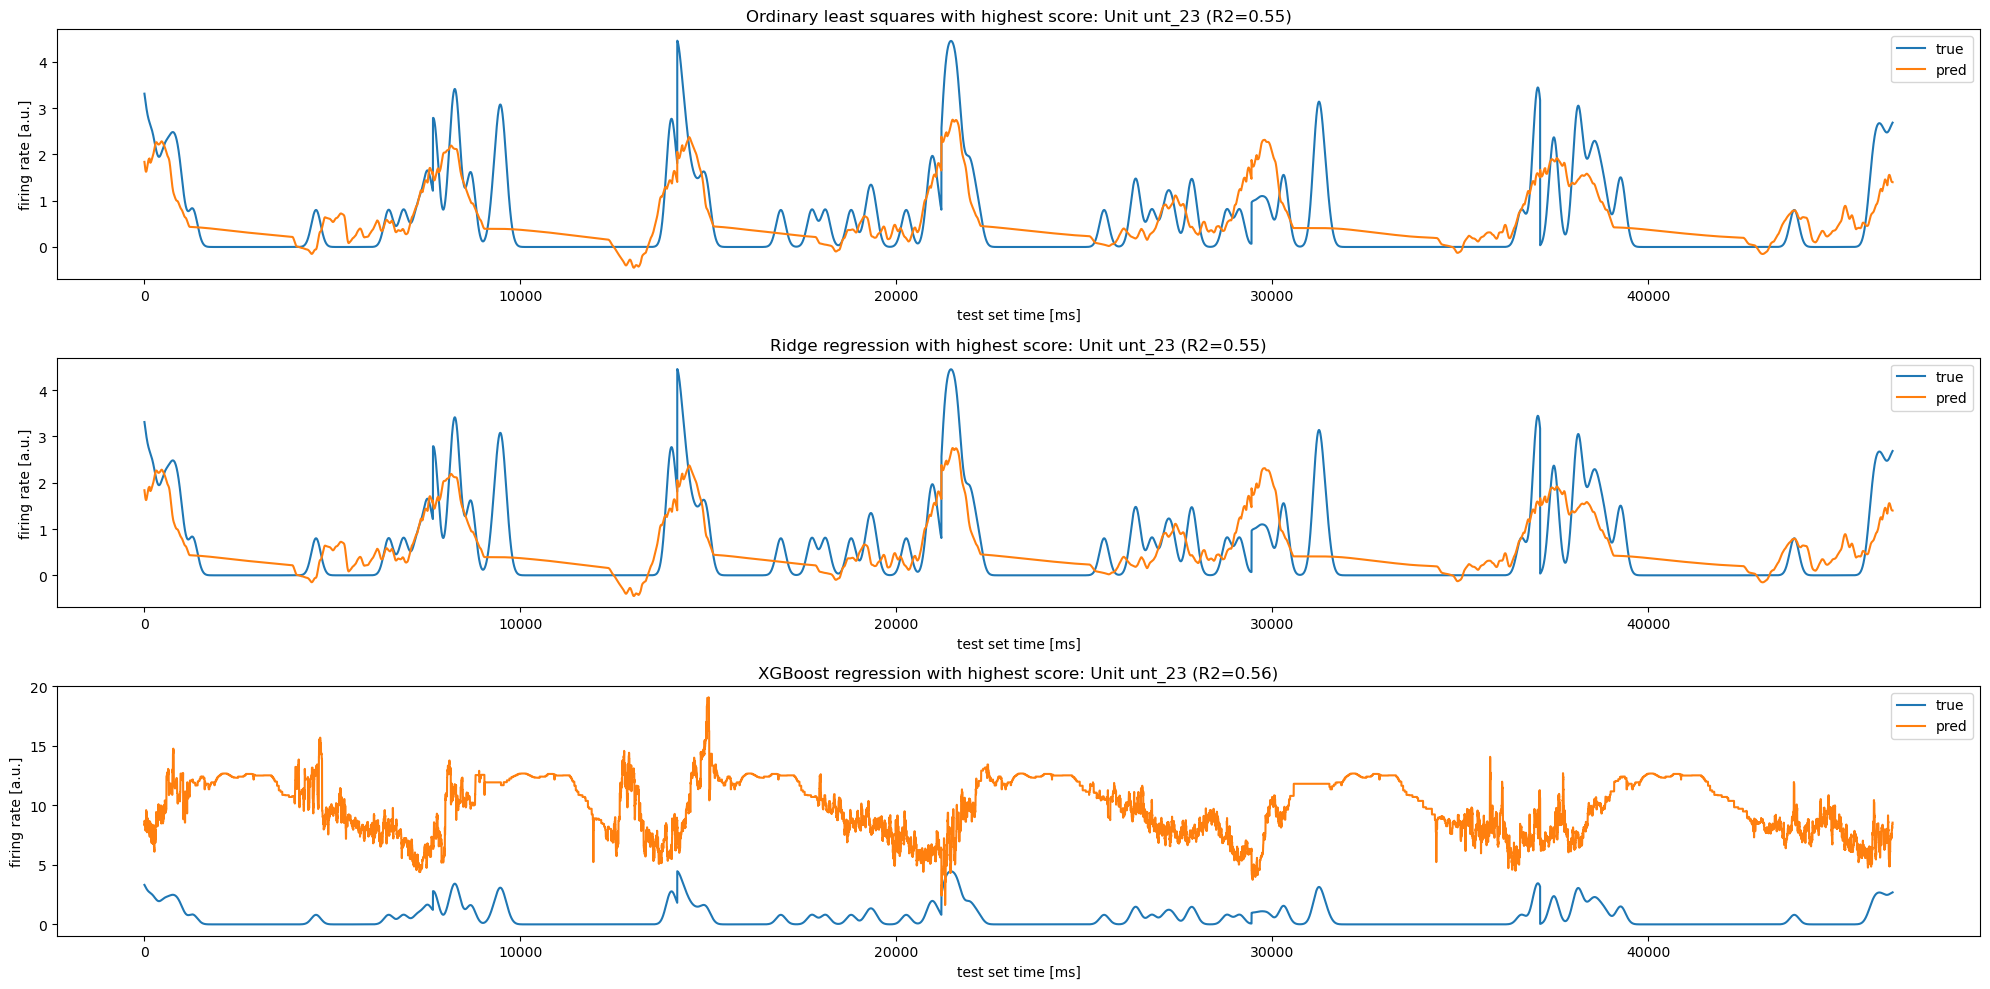

In [ ]:
# plot best scoring
fig, axarr = plt.subplots(nrows=3, figsize=(20, 10))

def plot(col, mod_dict):
    x = df_res.idxmax().loc[col]
    v = df_res.loc[x, col]
    test_y = test.loc[:, x]
    mod = mod_dict[x]
    ax.plot(steps2ms(test_y.values), label='true')
    ax.plot(steps2ms(mod.predict(test_X)), label='pred')
    ax.legend()
    return x, v

ax = axarr[0]
x, v = plot('lm_r2', mod_lm)
ax.set_title('Ordinary least squares with highest score: Unit {} (R2={:.2f})'.format(x, v))

ax = axarr[1]
x, v = plot('rdg_r2', mod_rdg)
ax.set_title('Ridge regression with highest score: Unit {} (R2={:.2f})'.format(x, v))

ax = axarr[2]
x, v = plot('xgbreg_r2', mod_xgbreg)
ax.set_title('XGBoost regression with highest score: Unit {} (R2={:.2f})'.format(x, v))

for ax in axarr:
    ax.set(
        xlabel='test set time [ms]',
        ylabel='firing rate [a.u.]'
    )

fig.tight_layout()

## unshuffled

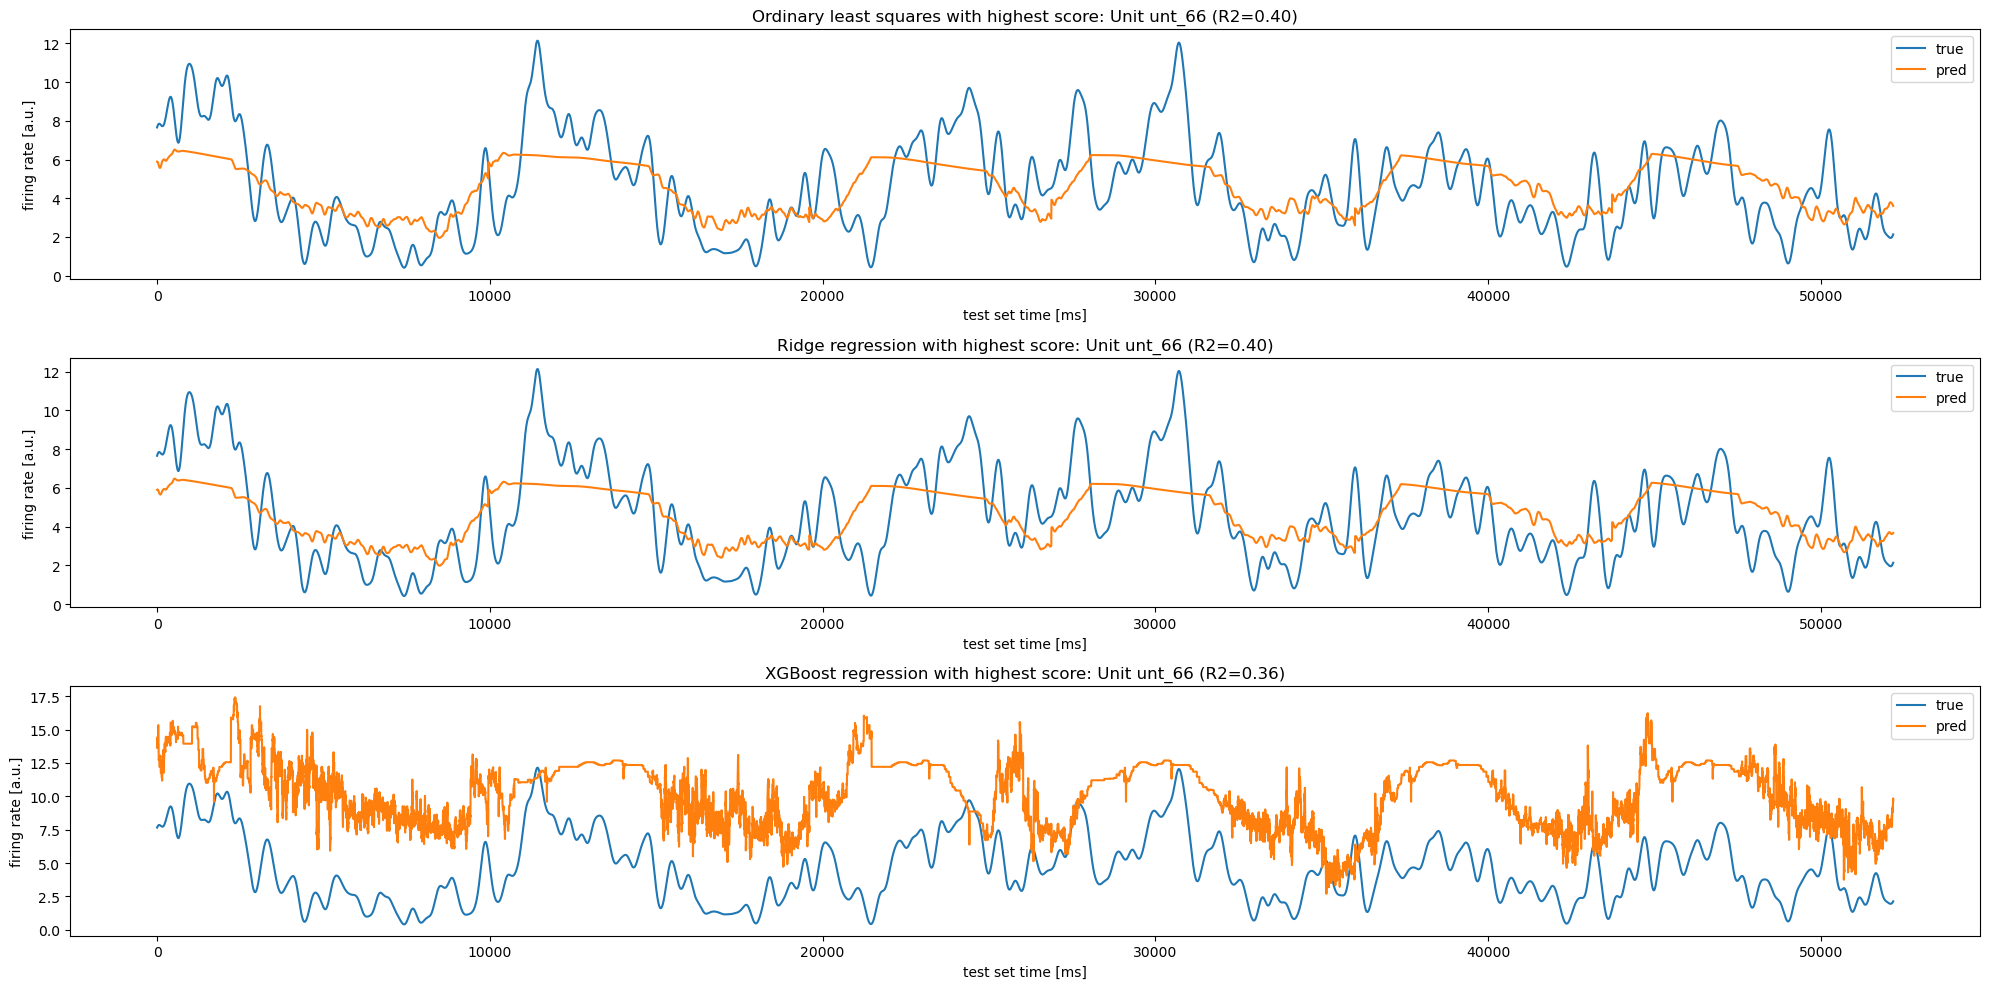

In [ ]:
# plot best scoring
fig, axarr = plt.subplots(nrows=3, figsize=(20, 10))

def plot(col, mod_dict):
    x = df_res.idxmax().loc[col]
    v = df_res.loc[x, col]
    test_y = test.loc[:, x]
    mod = mod_dict[x]
    ax.plot(steps2ms(test_y.values), label='true')
    ax.plot(steps2ms(mod.predict(test_X)), label='pred')
    ax.legend()
    return x, v

ax = axarr[0]
x, v = plot('lm_r2', mod_lm)
ax.set_title('Ordinary least squares with highest score: Unit {} (R2={:.2f})'.format(x, v))

ax = axarr[1]
x, v = plot('rdg_r2', mod_rdg)
ax.set_title('Ridge regression with highest score: Unit {} (R2={:.2f})'.format(x, v))

ax = axarr[2]
x, v = plot('xgbreg_r2', mod_xgbreg)
ax.set_title('XGBoost regression with highest score: Unit {} (R2={:.2f})'.format(x, v))

for ax in axarr:
    ax.set(
        xlabel='test set time [ms]',
        ylabel='firing rate [a.u.]'
    )

fig.tight_layout()

In [ ]:
## Smoothed to 

In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mod', LinearRegression())
])

mod_lm = dict()
for i in trg:
    train_y, test_y = train.loc[:, i], test.loc[:, i]

    mod = pipe.fit(train_X, train_y)
 
    df_res.loc[i, 'lm_r2'] = mod.score(test_X, test_y)
    mod_lm[i] = mod

# Counting models

In [ ]:
df_prc = pd.read_pickle('./data/preproc/df_prc_dwn.pickle') 
gr_prc = df_prc.groupby('trial') # data grouped by trials
dt = 125

# 95% train, 5% test, no shuffling 
# kf = KFold(20) # instead of train_test_split, each KFold is 95% train and 5% test (easier to change later)
# kfs = [ (i, j) for i, j in kf.split(ids_good) ] # expand generator
# ids_train, ids_test = kfs[-1] # -1 equivalent to 
ids_train, ids_test = train_test_split(ids_good, test_size=0.05, shuffle=False)

train = pd.concat([ gr_prc.get_group(s) for s in ids_train ])
test = pd.concat([ gr_prc.get_group(s) for s in ids_test ])

col_set = lambda x: [ i for i in df_prc if i.startswith(x) ]

train_X, test_X = train.loc[:, feat], test.loc[:, feat]

In [ ]:
est = xgb.XGBRegressor(
    objective='count:poisson',
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)


pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mod', est)
])

mod_xgbcnt = dict()
for i in trg:
    train_y, test_y = train.loc[:, i], test.loc[:, i]

    mod = pipe.fit(train_X, train_y)

    df_res.loc[i, 'xgbcnt_score'] = mod.score(test_X, test_y)
    mod_xgbcnt[i] = mod


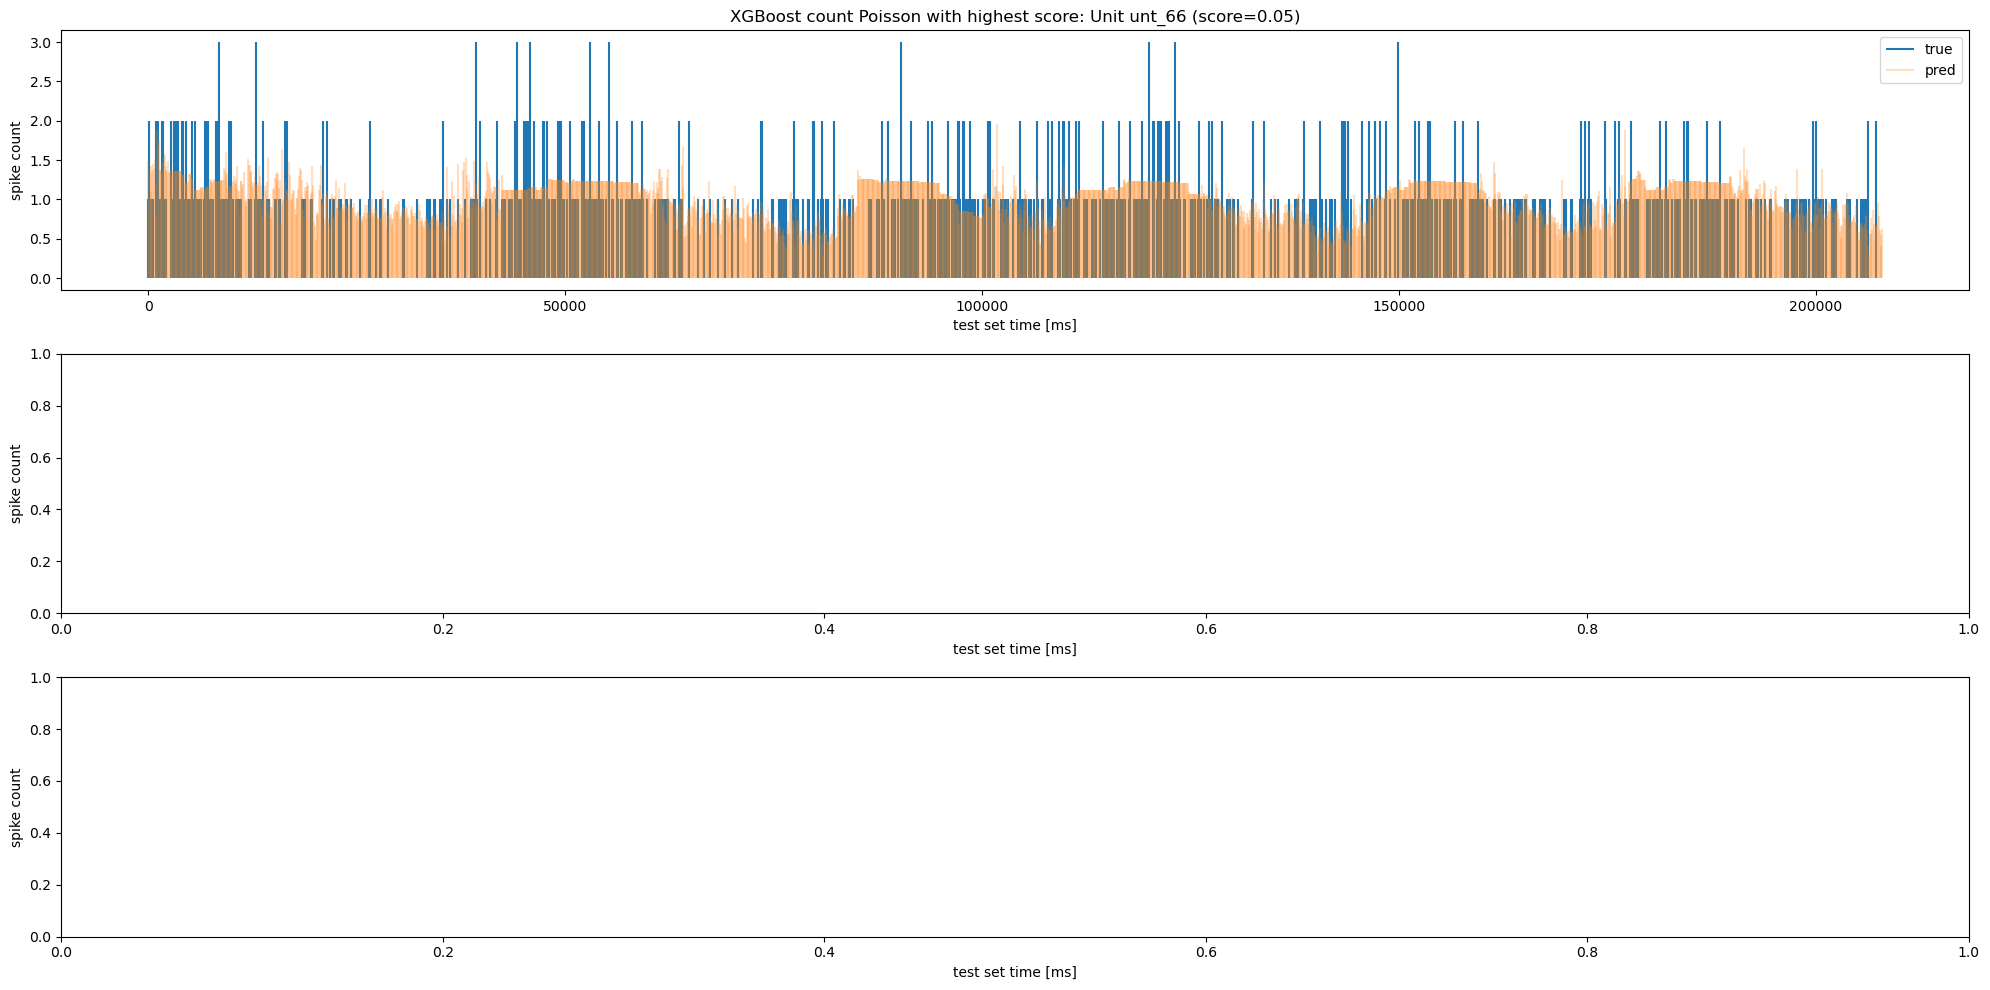

In [ ]:
# plot best scoring
fig, axarr = plt.subplots(nrows=3, figsize=(20, 10))

def plot(col, mod_dict):
    x = df_res.idxmax().loc[col]
    v = df_res.loc[x, col]
    test_y = test.loc[:, x]
    mod = mod_dict[x]

    ax.vlines(steps2ms(np.arange(len(test_y.index)) * dt), 0, test_y, label='true')
    test_y_pred = mod.predict(test_X)
    ax.vlines(steps2ms(np.arange(len(test_y_pred)) * dt), 0, test_y_pred, label='pred', color='C1', alpha=0.25)

    ax.legend()
    return x, v

ax = axarr[0]
x, v = plot('xgbcnt_score', mod_xgbcnt)
ax.set_title('XGBoost count Poisson with highest score: Unit {} (score={:.2f})'.format(x, v))


for ax in axarr:
    ax.set(
        xlabel='test set time [ms]',
        ylabel='spike count',
    )

fig.tight_layout()

In [ ]:
dm_train = xgb.DMatrix(data=train_X, label=train_y)
params = {
    'tree_method':  'gpu_hist',
    'objective':    'count:poisson',
    'predictor':    'gpu_predictor',
    # 'max_depth':    depth,
    # 'reg_lambda':   lamb,
    # 'reg_alpha':    alph,
}
model = xgb.train(params=params, dtrain=dm_train)
dm_test = xgb.DMatrix(data=test_X, label=test_y)

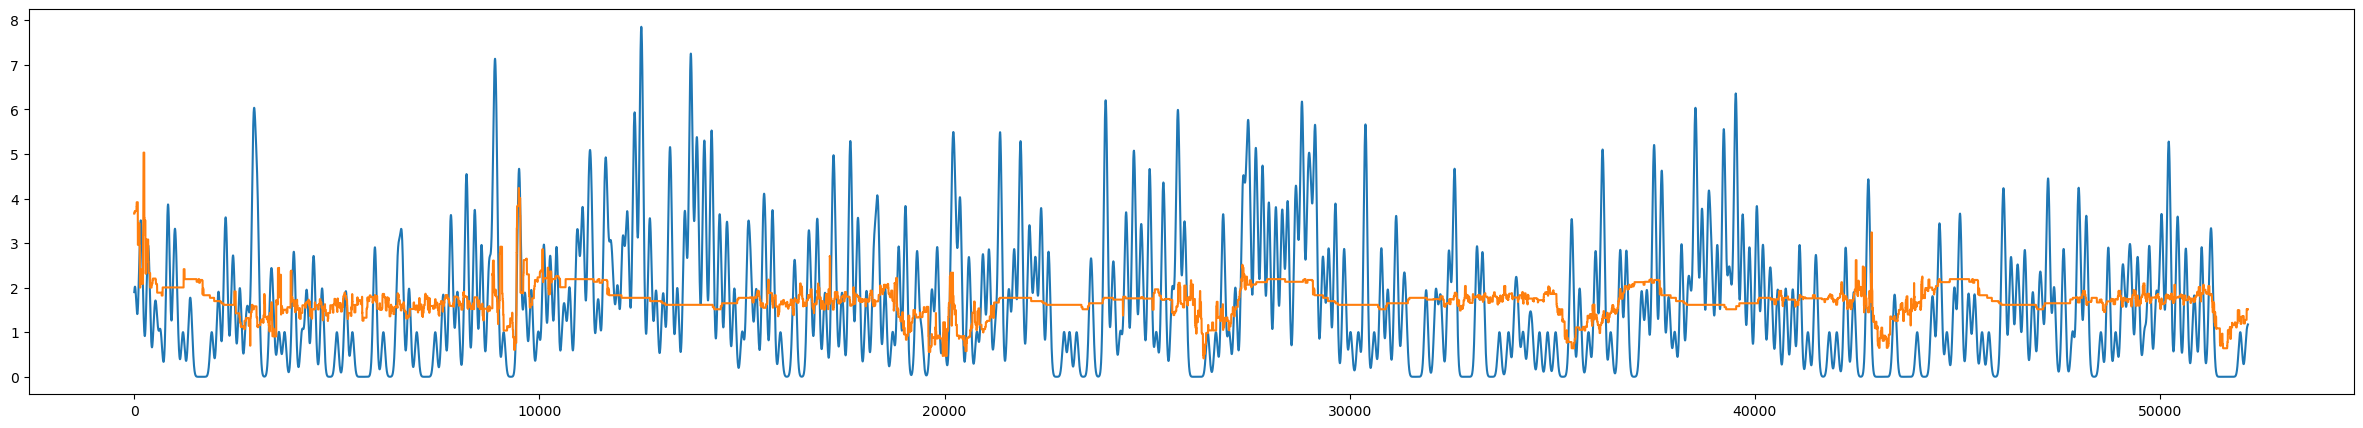

In [ ]:
fig, ax = plt.subplots(figsize=(30, 5))

ax.plot(test_y.values)
ax.plot(model.predict(dm_test))

# ax.set_xlim(150000, 153000)

In [ ]:
def poisson_deviance(y_true, y_pred):
    return 2 * np.sum(y_true * np.log(y_true / y_pred) - y_true + y_pred)


def explained_poisson_deviance(y_true, y_pred, y_train):
    return 1 - (
        poisson_deviance(y_true, y_pred) / poisson_deviance(y_true, y_train.mean())
    )
